<h1>Data setup</h1>
<h2>Use our function to read the data file</h2>

In [3]:
def read_311_data(datafile):
    import pandas as pd
    import numpy as np
    
    #Add the fix_zip function
    def fix_zip(input_zip):
        try:
            input_zip = int(float(input_zip))
        except:
            try:
                input_zip = int(input_zip.split('-')[0])
            except:
                return np.NaN
        if input_zip < 10000 or input_zip > 19999:
            return np.NaN
        return str(input_zip)
    
    #Read the file
    df = pd.read_csv(datafile,index_col='Unique Key')
    
    #fix the zip
    df['Incident Zip'] = df['Incident Zip'].apply(fix_zip)
    
    #drop all rows that have any nans in them (note the easier syntax!)
    
    df = df.dropna(how='any')
    
    #get rid of unspecified boroughs
    df = df[df['Borough'] != 'Unspecified']
    
    #Convert times to datetime and create a processing time column
    
    import datetime
    df['Created Date'] = df['Created Date'].apply(lambda x:datetime.datetime.strptime(x,'%m/%d/%y %H:%M'))
    df['Closed Date'] = df['Closed Date'].apply(lambda x:datetime.datetime.strptime(x,'%m/%d/%y %H:%M'))
    df['processing_time'] =  df['Closed Date'] - df['Created Date']
    
    #Finally, get rid of negative processing times and return the final data frame
    
    df = df[df['processing_time']>=datetime.timedelta(0,0,0)]
    
    return df
    

In [4]:
datafile = "nyc_311_data_subset-2.csv"
data = read_311_data(datafile)

/Users/Beck/anaconda/envs/tflearn/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


<h1>Plotting data on google maps</h1>
<h2>gmplot library</h2>
https://github.com/vgm64/gmplot

In [138]:
!pip install gmplot --upgrade

Requirement already up-to-date: gmplot in /Users/hardeepjohar/anaconda/lib/python3.5/site-packages
Requirement already up-to-date: requests in /Users/hardeepjohar/anaconda/lib/python3.5/site-packages (from gmplot)
Requirement already up-to-date: chardet<3.1.0,>=3.0.2 in /Users/hardeepjohar/anaconda/lib/python3.5/site-packages (from requests->gmplot)
Requirement already up-to-date: idna<2.6,>=2.5 in /Users/hardeepjohar/anaconda/lib/python3.5/site-packages (from requests->gmplot)
Requirement already up-to-date: certifi>=2017.4.17 in /Users/hardeepjohar/anaconda/lib/python3.5/site-packages (from requests->gmplot)
Requirement already up-to-date: urllib3<1.22,>=1.21.1 in /Users/hardeepjohar/anaconda/lib/python3.5/site-packages (from requests->gmplot)


<h3>Our data dataframe contains latitudes and longitudes for each complaint.</h3>
<h3>We can draw a heatmap that will help us see the relative concentration of complaints using lats and lons</h3>



<h3>Set up the map</h3>
<h4>GoogleMapPlotter constructor</h4>
<ul>
<li>GoogleMapPlotter(center_lat, center_lng, zoom)
<li>from_geocode(location_string,zoom)


In [6]:

import gmplot
#gmap = gmplot.GoogleMapPlotter(40.7128, -74.0059, 8)


gmap = gmplot.GoogleMapPlotter.from_geocode("New York",10)


<h3>Then generate the heatmap passing the two data series (latitude and longitude) to the function</h3>

In [7]:
#Then generate a heatmap using the latitudes and longitudes
gmap.heatmap(data['Latitude'], data['Longitude'])

<h3>Save the heatmap to an html file</h3>
<h4>The html file can be viewed, printed, or included in another html page</h4>

In [8]:
gmap.draw('incidents3.html')

<h1>Let's do some grouping operations</h1>

<h2>Incidents by Borough</h2>

In [9]:
%matplotlib inline

<h2>Group data by borough and plot a bar chart of the incident count</h2>

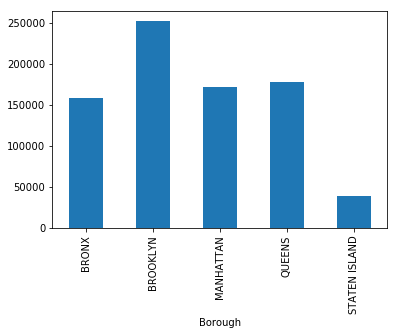

In [10]:

borough_group = data.groupby('Borough')
borough_group.size().plot(kind='bar')
#kind can be 'hist', 'scatter'

<h1>Incidents by Agency</h1>

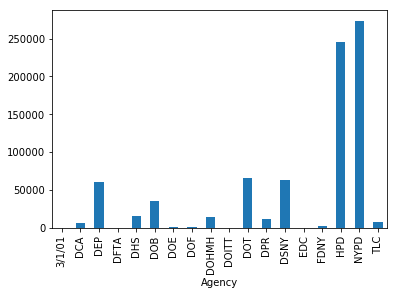

In [11]:
agency_group = data.groupby('Agency')
agency_group.size().plot(kind='bar')

<h2>Let's combine the two in a single graph</h2>


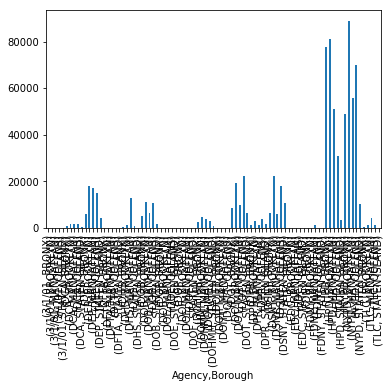

In [12]:

agency_borough = data.groupby(['Agency','Borough'])
agency_borough.size().plot(kind='bar')


<h2>This is quite unreadable and pointless!</h2>

<h3>We can unstack the groups so that we get borough by agency</h3>

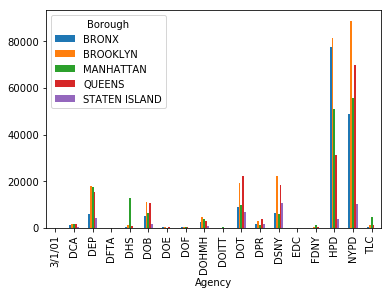

In [13]:
agency_borough.size().unstack().plot(kind='bar')

<h3>Increase the size of the image and add a title</h3>

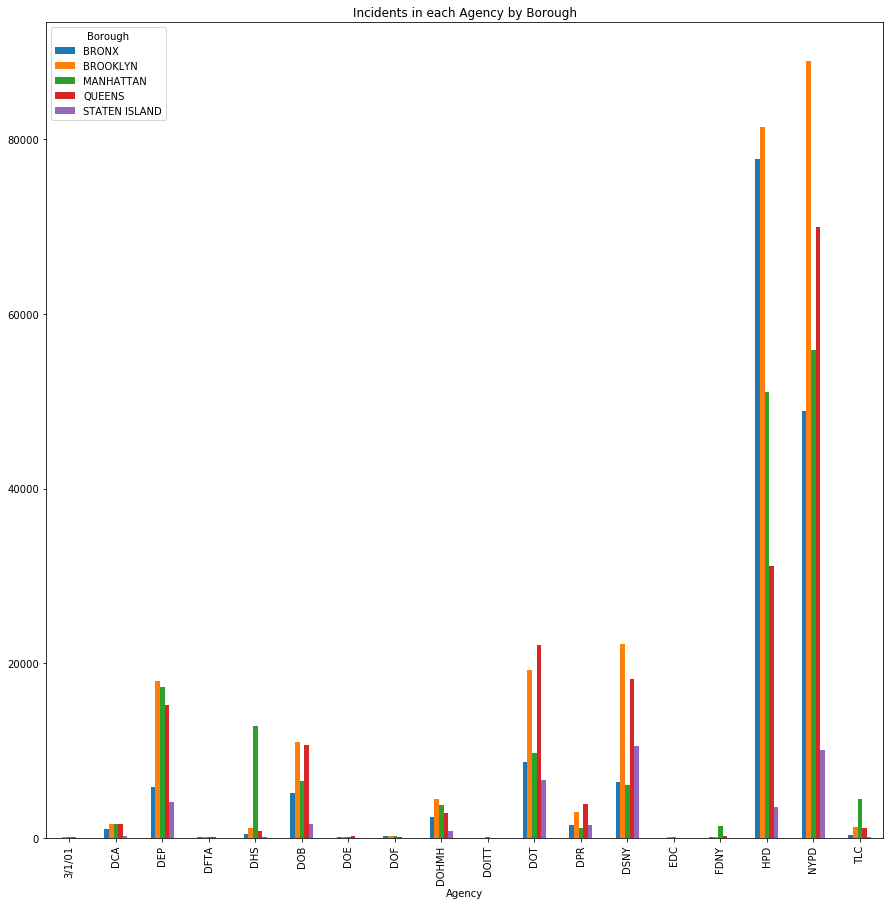

In [14]:

agency_borough = data.groupby(['Agency','Borough'])
agency_borough.size().unstack().plot(kind='bar',title="Incidents in each Agency by Borough",figsize=(15,15))


<h1>Digression: The pandas groupby function</h1>

<h4>You can use functions to group data</h4>

In [15]:
import pandas as pd
writers = pd.DataFrame({'Author':['George Orwell','John Steinbeck',
                                  'Pearl Buck','Agatha Christie'],
                        'Country':['UK','USA','USA','UK'],
                        'Gender':['M','M','F','F'],
                        'Age':[46,66,80,85]})
                        


In [16]:
writers

,Age,Author,Country,Gender
0,46,George Orwell,UK,M
1,66,John Steinbeck,USA,M
2,80,Pearl Buck,USA,F
3,85,Agatha Christie,UK,F


<h4>Group by country</h4>

In [23]:
grouped = writers.groupby('Country')
#grouped.first()
#grouped.last()
#grouped.sum()
#grouped.mean()
grouped.apply(sum)

,Age,Author,Country,Gender
Country,,,,
UK,131,George OrwellAgatha Christie,UKUK,MF
USA,146,John SteinbeckPearl Buck,USAUSA,MF


In [24]:
grouped.groups

{'UK': Int64Index([0, 3], dtype='int64'),
 'USA': Int64Index([1, 2], dtype='int64')}

<h4>Group by multiple columns</h4>

In [25]:
grouped = writers.groupby(['Country','Gender'])
grouped.groups

{('UK', 'F'): Int64Index([3], dtype='int64'),
 ('UK', 'M'): Int64Index([0], dtype='int64'),
 ('USA', 'F'): Int64Index([2], dtype='int64'),
 ('USA', 'M'): Int64Index([1], dtype='int64')}

<h4>Group by age groups</h4>

In [32]:
def age_groups(df,index,col):
    print(index,col)
    if df[col].iloc[index] < 30:
        return 'Young'
    if df[col].iloc[index] < 60:
        return 'Middle'
    else:
        return 'Old'

In [44]:
writers['Age'].iloc[0]

46

In [34]:
grouped = writers.groupby(lambda x: age_groups(writers,x,'Age'))
grouped.groups

0 Age
1 Age
2 Age
3 Age


{'Middle': Int64Index([0], dtype='int64'),
 'Old': Int64Index([1, 2, 3], dtype='int64')}

<h2>Grouping by the values in a column</h2>
<h3>For example, grouping the data by values in a column that are greater than or less than zero</h3>

In [36]:
import numpy as np
people = pd.DataFrame(np.random.randn(5, 5), columns=['a', 'b', 'c', 'd', 'e'], index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])
people

,a,b,c,d,e
Joe,-0.249511,0.829799,1.782724,1.175463,-0.494082
Steve,0.359809,-0.235219,-3.068322,-0.183199,-0.598801
Wes,0.932746,-1.146177,-0.672963,-0.348038,-0.760377
Jim,0.775882,-1.659168,-0.301639,-0.000548,1.163943
Travis,-0.254044,-1.601734,-0.024121,-0.250024,-0.266271


<h3>Write a function that takes three arguments - a dataframe, an index, and a column name and returns the grouping for that row</h3>

In [41]:
def GroupColFunc(df, ind, col):
    if df[col].loc[ind] > 0:
        return 'Group1'
    else:
        return 'Group2'

In [42]:
people.groupby(lambda x: GroupColFunc(people, x, 'a')).groups

{'Group1': Index(['Steve', 'Wes', 'Jim'], dtype='object'),
 'Group2': Index(['Joe', 'Travis'], dtype='object')}

<h2>Now we can compute stats on these groups</h2>

In [45]:
print(people.groupby(lambda x: GroupColFunc(people, x, 'a')).mean())
print(people.groupby(lambda x: GroupColFunc(people, x, 'a')).std())

               a         b         c         d         e
Group1  0.689479 -1.013521 -1.347641 -0.177262 -0.065078
Group2 -0.251777 -0.385968  0.879301  0.462719 -0.380177
               a         b         c         d         e
Group1  0.296080  0.721184  1.501675  0.173821  1.067425
Group2  0.003205  1.719354  1.277633  1.007971  0.161087


<h1>Incidents by time</h1>
<p>We know the creation date of each incident so we can build a bar graph of number of incidents by month
<p>Not particularly useful with a few months data but if we had all data from 2010, we could use this sort of
analysis to eyeball trends and seasonality
<p>We're going to need to do some data manipulation for this

<h3>We'll start by creating a new date field yyyymm

In [46]:
import datetime
data['yyyymm'] = data['Created Date'].apply(lambda x:datetime.datetime.strftime(x,'%Y%m'))

In [47]:
data['yyyymm']

Unique Key
11        201609
12        201609
13        201609
14        201609
15        201609
16        201609
17        201609
18        201609
19        201609
20        201609
21        201609
22        201609
23        201609
24        201609
25        201609
26        201609
27        201609
28        201609
30        201609
31        201609
32        201609
33        201609
34        201609
35        201609
36        201609
37        201609
38        201609
39        201609
40        201609
41        201609
           ...  
971012    201609
971014    201609
971018    201609
971021    201609
971022    201609
971023    201609
971025    201609
971031    201609
971032    201609
971034    201609
971035    201609
971036    201609
971038    201609
971040    201609
971041    201609
971043    201609
971044    201609
971046    201609
971047    201609
971049    201609
971052    201609
971053    201609
971055    201609
971056    201609
971057    201609
971059    201609
971060    201609
971

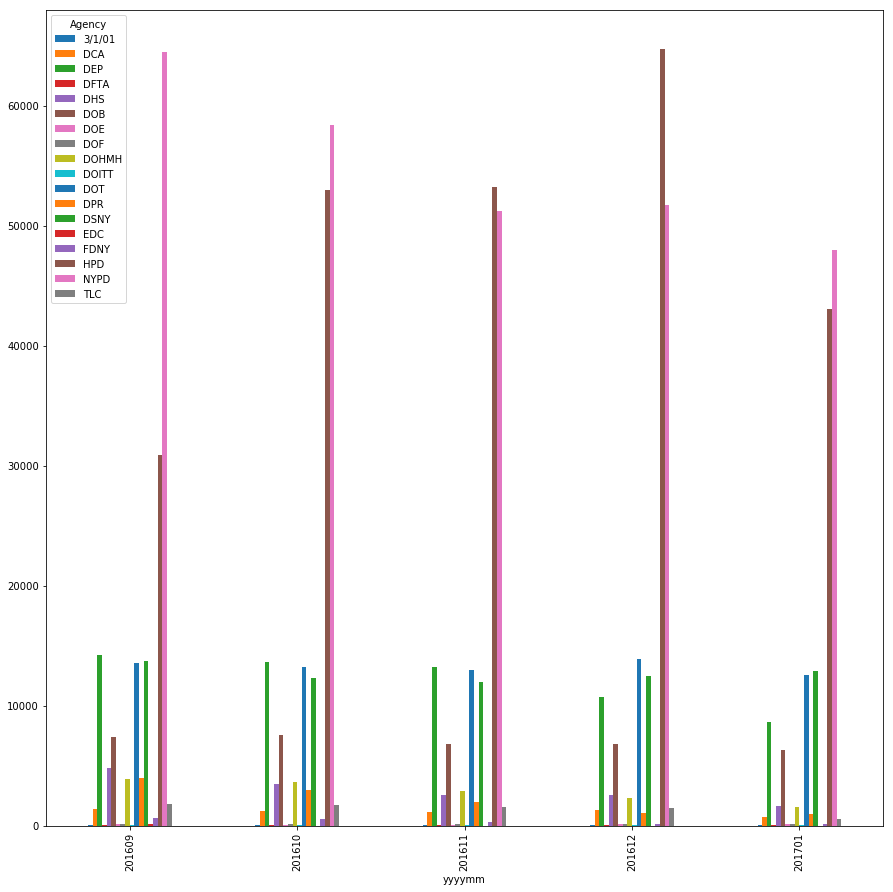

In [48]:
date_agency = data.groupby(['yyyymm','Agency'])
date_agency.size().unstack().plot(kind='bar',figsize=(15,15))

<h1>Examining agencies</h1>

<h2>We'll look at the frequency by agency and report the top 5 values</h2>

In [49]:
data.groupby('Agency').size().sort_values(ascending=False)

Agency
NYPD      273683
HPD       244815
DOT        66180
DSNY       63321
DEP        60346
DOB        34821
DHS        15083
DOHMH      14188
DPR        10830
TLC         7129
DCA         5760
FDNY        1676
DOF          579
DOE          454
DOITT        134
EDC          123
3/1/01       102
DFTA         101
dtype: int64

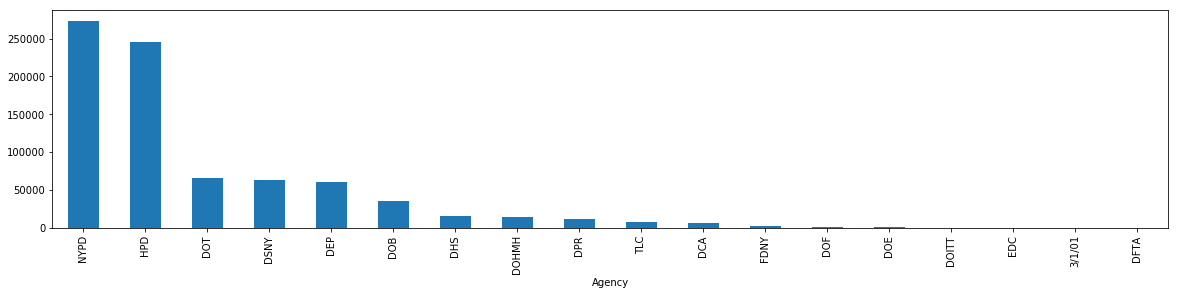

In [50]:
data.groupby('Agency').size().sort_values(ascending=False).plot(kind='bar', figsize=(20,4))

<h3>We can drill down into complaints by Agency by borough</h3>

In [51]:
agency_borough = data.groupby(['Agency', 'Borough']).size().unstack()

In [52]:
agency_borough

Borough,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
Agency,,,,,
3/1/01,17.0,28.0,23.0,28.0,6.0
DCA,958.0,1532.0,1529.0,1547.0,194.0
DEP,5837.0,17917.0,17315.0,15216.0,4061.0
DFTA,21.0,33.0,24.0,21.0,2.0
DHS,397.0,1130.0,12767.0,734.0,55.0
DOB,5160.0,10993.0,6507.0,10567.0,1594.0
DOE,129.0,127.0,49.0,136.0,13.0
DOF,143.0,161.0,153.0,112.0,10.0
DOHMH,2406.0,4481.0,3759.0,2814.0,728.0


<h3>We can create 'top 5 Agency' subplots subplots for each borough</h3>

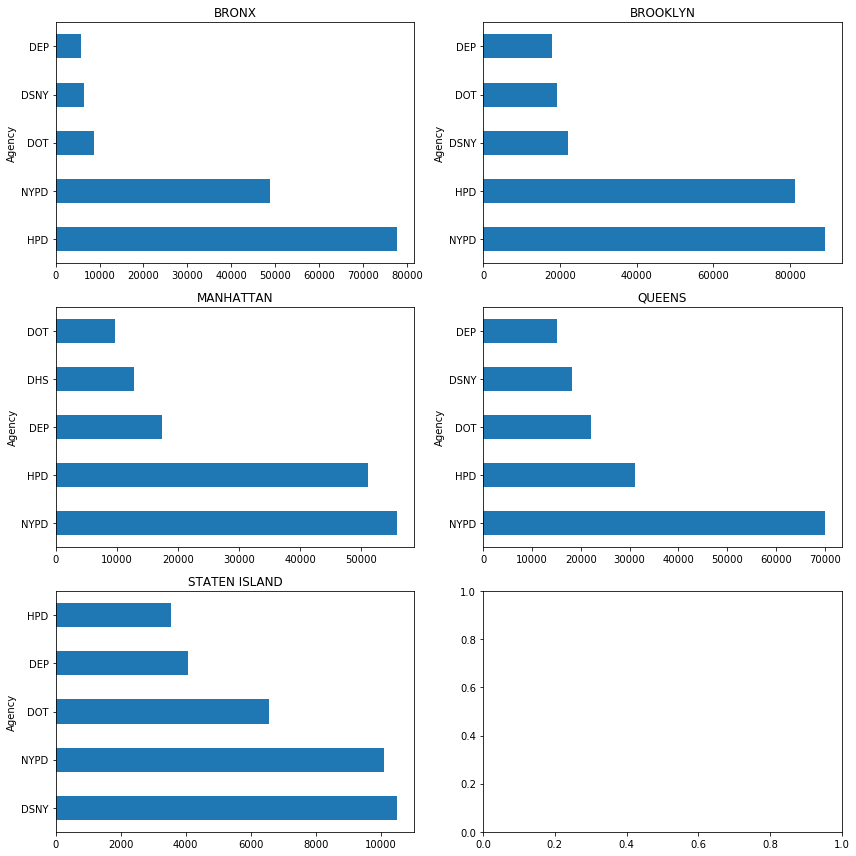

In [53]:
#We'll arrange the subplots in two rows and three columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 2
ROW_NUM = 3
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(12,12))

for i, (label, col) in enumerate(agency_borough.iteritems()): 
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    col = col.sort_values(ascending=False)[:5] 
    col.plot(kind='barh', ax=ax)
    ax.set_title(label)

plt.tight_layout() 

In [54]:
for i, (label, col) in enumerate(agency_borough.iteritems()): 
    print(i,label,col)

0 BRONX Agency
3/1/01       17.0
DCA         958.0
DEP        5837.0
DFTA         21.0
DHS         397.0
DOB        5160.0
DOE         129.0
DOF         143.0
DOHMH      2406.0
DOITT         7.0
DOT        8683.0
DPR        1416.0
DSNY       6406.0
EDC           1.0
FDNY         39.0
HPD       77774.0
NYPD      48837.0
TLC         318.0
Name: BRONX, dtype: float64
1 BROOKLYN Agency
3/1/01       28.0
DCA        1532.0
DEP       17917.0
DFTA         33.0
DHS        1130.0
DOB       10993.0
DOE         127.0
DOF         161.0
DOHMH      4481.0
DOITT        18.0
DOT       19177.0
DPR        2929.0
DSNY      22208.0
EDC          62.0
FDNY        127.0
HPD       81382.0
NYPD      88973.0
TLC        1238.0
Name: BROOKLYN, dtype: float64
2 MANHATTAN Agency
3/1/01       23.0
DCA        1529.0
DEP       17315.0
DFTA         24.0
DHS       12767.0
DOB        6507.0
DOE          49.0
DOF         153.0
DOHMH      3759.0
DOITT        91.0
DOT        9673.0
DPR        1103.0
DSNY       6079.0
EDC    

<h1>Processing time</h1>
<h2>We can compute simple statistics on processing time</h2>

In [ ]:
grouped = data[['processing_time','Borough']].groupby('Borough')

In [ ]:
grouped.describe()

<h3>But it is easier to convert the timedelta processing_time into floats for calculation purposes</h3>

In [ ]:
import numpy as np
#The time it takes to process. Cleaned up
data['float_time'] =data['processing_time'].apply(lambda x:x/np.timedelta64(1, 'D'))

In [ ]:
data

<h2>Now we can compute stats easily</h2>

In [ ]:
grouped = data[['float_time','Agency']].groupby('Agency')
grouped.mean().sort_values('float_time',ascending=False)

In [ ]:
data['float_time'].hist(bins=50)

<h1>Other useful visualization libraries</h1>
<h2>seaborn: https://seaborn.pydata.org/</h2>
<h2>bokeh: http://bokeh.pydata.org/en/latest/</h2>
<h2>plotly: https://plot.ly/</h2>
